This notebook plots the expected impact of IGM extinction on the LSST bands

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lbg_survey_metrics.constants import *
from lbg_survey_metrics.igm import *

In [2]:
bandpass_dir = "data/rubin_sim_data/throughputs/baseline/"

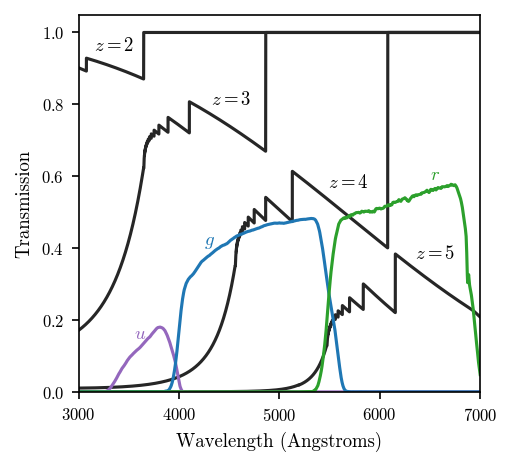

In [3]:
# Plot IGM extinction and the Rubin filters at multiple redshifts
fig, ax = plt.subplots(figsize=single_col, constrained_layout=True, dpi=150)

wavelen = np.linspace(3_000, 7_000, 10_000)

for z in [2, 3, 4, 5]:
    ax.plot(wavelen, T(wavelen, z), c=colors["black"])

for band in "ugr":
    w, R = np.genfromtxt(f"{bandpass_dir}/total_{band}.dat", unpack=True)
    ax.plot(10 * w, R, c=colors[band])

ax.set(
    xlim=(wavelen.min(), wavelen.max()),
    ylim=(0, 1.05),
    xlabel="Wavelength (Angstroms)",
    ylabel="Transmission",
    xticks=[3e3, 4e3, 5e3, 6e3, 7e3],
)

ax.text(3150, 0.95, "$z=2$")
ax.text(4320, 0.80, "$z=3$")
ax.text(5480, 0.57, "$z=4$")
ax.text(6350, 0.37, "$z=5$")

ax.text(3550, 0.15, "$u$", color=colors["u"])
ax.text(4250, 0.41, "$g$", color=colors["g"])
ax.text(6500, 0.59, "$r$", color=colors["r"])

fig.savefig("figures/igm_transmission_curves.pdf")

In [4]:
# Calculate extinction in each band
zs = np.linspace(1.5, 6.5, 100)

dms = {"u": [], "g": [], "r": [], "i": []}

# Loop over bands
for band in "ugri":
    # Load and normalize bandpass
    w, R = np.genfromtxt(f"{bandpass_dir}/total_{band}.dat", unpack=True)
    w *= 10
    R = w * R / np.trapz(w * R, w)

    # Calculate min and max wavelengths for truncation
    weff = np.trapz(R * w, w)
    wmin = weff - 1000
    wmax = weff + 1000
    idx_min = np.abs(w - wmin).argmin()
    idx_max = np.abs(w - wmax).argmin()
    w = w[idx_min:idx_max]
    R = R[idx_min:idx_max]
    
    # Loop over redshifts
    for z in zs:
        # Get transmission
        trans = T(w, z)
        
        # Set UV slope
        beta = -2

        # Re-weight the bandpass
        Rt = R * w ** beta / np.trapz(R * w ** beta, w)

        # Calculate the flux ratio
        ratio = np.trapz(Rt * trans, w)

        # Calculate the magnitude increment
        dm = dm = -2.5 * np.log10(ratio)
        dms[band].append(dm)
            
dms = {key: np.array(val) for key, val in dms.items()}

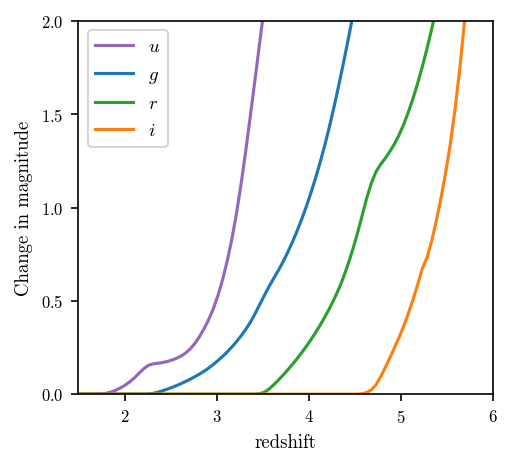

In [5]:
# Plot IGM extinction in each band
fig, ax = plt.subplots(figsize=single_col, constrained_layout=True, dpi=150)

ax.plot(zs, dms["u"], c=colors["u"], label="$u$")
ax.plot(zs, dms["g"], c=colors["g"], label="$g$")
ax.plot(zs, dms["r"], c=colors["r"], label="$r$")
ax.plot(zs, dms["i"], c=colors["i"], label="$i$")

ax.legend()
ax.set(
    xlabel="redshift",
    ylabel="Change in magnitude",
    ylim=(0, 2),
    xlim=(zs.min(), 6),
    yticks=np.arange(0, 2.5, 0.5),
)

#ax.axhline(1, ls="--", c=black)
#ax.axvline(3.22, ls="--", c=colors["u"], alpha=0.4)
#ax.axvline(3.97, ls="--", c=colors["g"], alpha=0.4)
#ax.axvline(4.6, ls="--", c=colors["r"], alpha=0.4)
#ax.axvline(5.42, ls="--", c=colors["i"], alpha=0.4)

fig.savefig("figures/igm_magnitude_curves.pdf")

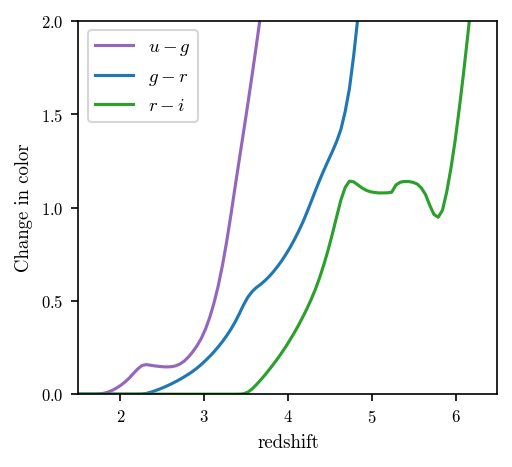

In [6]:
# Plot impact on colors
fig, ax = plt.subplots(figsize=single_col, constrained_layout=True, dpi=150)

ax.plot(zs[:80], (dms["u"] - dms["g"])[:80], c=colors["u"], label="$u-g$")
ax.plot(zs, dms["g"] - dms["r"], c=colors["g"], label="$g-r$")
ax.plot(zs, dms["r"] - dms["i"], c=colors["r"], label="$r-i$")

ax.legend()
ax.set(
    xlabel="redshift",
    ylabel="Change in color",
    ylim=(0, 2),
    xlim=(zs.min(), zs.max()),
    yticks=np.arange(0, 2.5, 0.5),
)

#ax.axhline(1, ls="--", c=black)
#ax.axvline(3.32, ls="--", c=colors["u"], alpha=0.4)
#ax.axvline(4.24, ls="--", c=colors["g"], alpha=0.4)
#ax.axvline(4.61, ls="--", c=colors["r"], alpha=0.4)

fig.savefig("figures/igm_color_curves.pdf")